In [1]:
# ==========================================
# BAGIAN 1: IMPORT LIBRARIES
# ==========================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import warnings
import os
os.environ['PILLOW_VERSION'] = '1'  # Force Keras to use Pillow
from PIL import Image
print("Pillow is working!")

# Kemudian import Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

Pillow is working!
TensorFlow version: 2.19.0
GPU Available: []


In [2]:
# ==========================================
# BAGIAN 2: KONFIGURASI DAN PARAMETER
# ==========================================

# Konfigurasi dataset
DATASET_PATH = "dataset"  # Ganti dengan path dataset Anda
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 35
LEARNING_RATE = 0.001

# Class names
CLASS_NAMES = ['no-vest', 'vest']

print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Classes: {CLASS_NAMES}")


Image Size: (224, 224)
Batch Size: 32
Classes: ['no-vest', 'vest']


In [3]:
# ==========================================
# BAGIAN 3: FUNGSI UNTUK PARSE DATASET YOLO
# ==========================================

def parse_yolo_dataset(dataset_path):
    """
    Parse dataset dengan struktur YOLO untuk klasifikasi
    Return: list of dictionaries dengan image_path, label, dan split
    """
    all_data = []
    splits = ['train', 'valid', 'test']
    
    for split in splits:
        img_dir = os.path.join(dataset_path, split, 'images')
        label_dir = os.path.join(dataset_path, split, 'labels')
        
        if not os.path.exists(img_dir):
            print(f"Warning: Directory {img_dir} tidak ditemukan")
            continue
            
        print(f"Processing {split} split...")
        
        for img_file in os.listdir(img_dir):
            if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(img_dir, img_file)
                
                # Cari file label yang sesuai
                label_file = img_file.rsplit('.', 1)[0] + '.txt'
                label_path = os.path.join(label_dir, label_file)
                
                # Tentukan label berdasarkan keberadaan anotasi
                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        lines = f.readlines()

                    # Ambil semua class_id dari setiap baris anotasi
                    class_ids = [int(line.strip().split()[0]) for line in lines if line.strip()]

                    # Jika ada class_id == 1, berarti vest
                    if 0 in class_ids:
                        label = 'vest'
                    elif 1 in class_ids:
                        label = 'no-vest'
                    else:
                        label = 'unknown'  # fallback jika class_id-nya tidak 0/1
                else:
                # Jika tidak ada file label, fallback (opsional bisa jadi 'no-vest' atau 'unknown')
                    label = 'no-vest'
                         
                all_data.append({
                    'image_path': img_path,
                    'label': label,
                    'split': split
                })
    
    return all_data


Parsing YOLO dataset...
Processing train split...
Processing valid split...
Processing test split...

Total images found: 2503

Distribusi data per split:
split
train    1841
valid     531
test      131
Name: count, dtype: int64

Distribusi label:
label
vest       1904
no-vest     599
Name: count, dtype: int64

Distribusi label per split:
label  no-vest  vest
split               
test        29   102
train      436  1405
valid      134   397


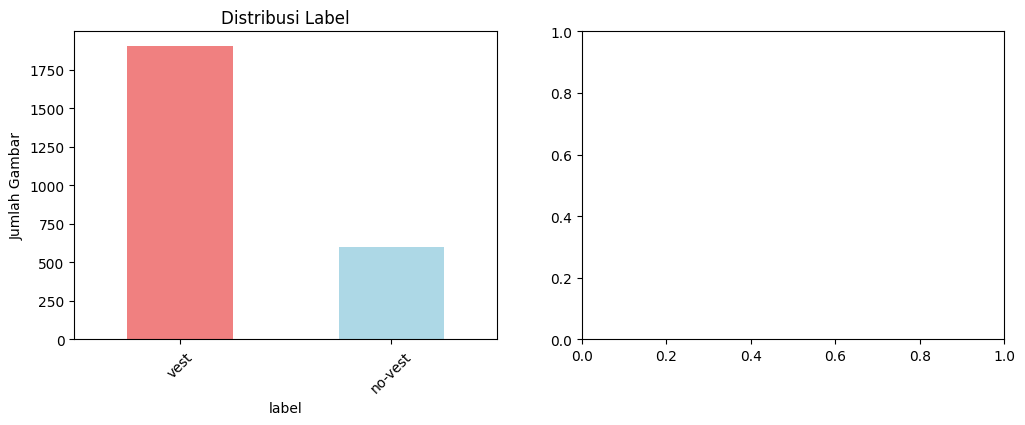

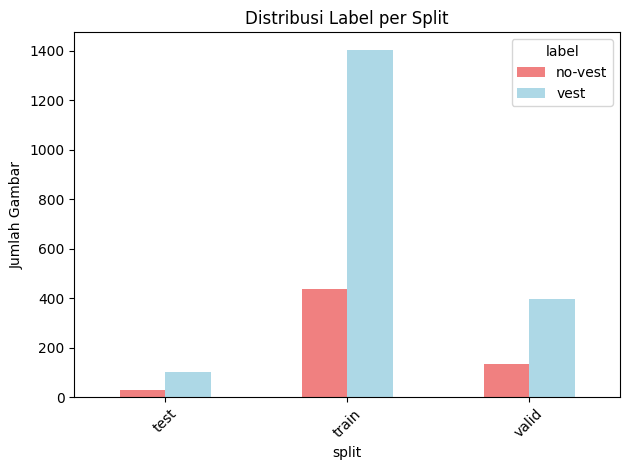

In [4]:
# ==========================================
# BAGIAN 4: LOAD DAN ANALISIS DATASET
# ==========================================

# Parse dataset
print("Parsing YOLO dataset...")
dataset_info = parse_yolo_dataset(DATASET_PATH)

# Convert ke DataFrame untuk analisis
df = pd.DataFrame(dataset_info)
print(f"\nTotal images found: {len(df)}")
print("\nDistribusi data per split:")
print(df['split'].value_counts())
print("\nDistribusi label:")
print(df['label'].value_counts())
print("\nDistribusi label per split:")
print(pd.crosstab(df['split'], df['label']))

# Visualisasi distribusi
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Distribusi Label')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
pd.crosstab(df['split'], df['label']).plot(kind='bar', color=['lightcoral', 'lightblue'])
plt.title('Distribusi Label per Split')
plt.ylabel('Jumlah Gambar')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# ==========================================
# BAGIAN 5: FUNGSI PREPROCESSING GAMBAR
# ==========================================

def load_and_preprocess_image(img_path, img_size=IMG_SIZE):
    """
    Load dan preprocess gambar
    """
    try:
        # Baca gambar
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Tidak dapat membaca gambar {img_path}")
            return None
            
        # Convert BGR ke RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize gambar
        image = cv2.resize(image, img_size)
        
        # Normalisasi pixel values ke [0, 1]
        image = image.astype(np.float32) / 255.0
        
        return image
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

def create_dataset_from_dataframe(df, img_size=IMG_SIZE):
    """
    Create numpy arrays dari DataFrame
    """
    images = []
    labels = []
    
    print("Loading and preprocessing images...")
    for idx, row in df.iterrows():
        if idx % 500 == 0:
            print(f"Processed {idx}/{len(df)} images")
            
        img = load_and_preprocess_image(row['image_path'], img_size)
        if img is not None:
            images.append(img)
            labels.append(row['label'])
    
    print(f"Successfully loaded {len(images)} images")
    return np.array(images), np.array(labels)


In [6]:
# ==========================================
# BAGIAN 6: LOAD DAN SPLIT DATASET
# ==========================================

# Jika dataset sudah ter-split dalam folder YOLO
train_df = df[df['split'] == 'train'].copy()
val_df = df[df['split'] == 'valid'].copy()
test_df = df[df['split'] == 'test'].copy()

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Load images untuk setiap split
print("\n=== Loading Training Data ===")
X_train, y_train = create_dataset_from_dataframe(train_df)

print("\n=== Loading Validation Data ===")
X_val, y_val = create_dataset_from_dataframe(val_df)

print("\n=== Loading Test Data ===")
X_test, y_test = create_dataset_from_dataframe(test_df)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"\nLabel mapping: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
print(f"Final dataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train_encoded.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val_encoded.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test_encoded.shape}")

Train samples: 1841
Validation samples: 531
Test samples: 131

=== Loading Training Data ===
Loading and preprocessing images...
Processed 0/1841 images
Processed 500/1841 images
Processed 1000/1841 images
Processed 1500/1841 images
Successfully loaded 1841 images

=== Loading Validation Data ===
Loading and preprocessing images...
Processed 2000/531 images
Successfully loaded 531 images

=== Loading Test Data ===
Loading and preprocessing images...
Processed 2500/131 images
Successfully loaded 131 images

Label mapping: {np.str_('no-vest'): np.int64(0), np.str_('vest'): np.int64(1)}
Final dataset shapes:
X_train: (1841, 224, 224, 3), y_train: (1841,)
X_val: (531, 224, 224, 3), y_val: (531,)
X_test: (131, 224, 224, 3), y_test: (131,)


Sample gambar dari training set:


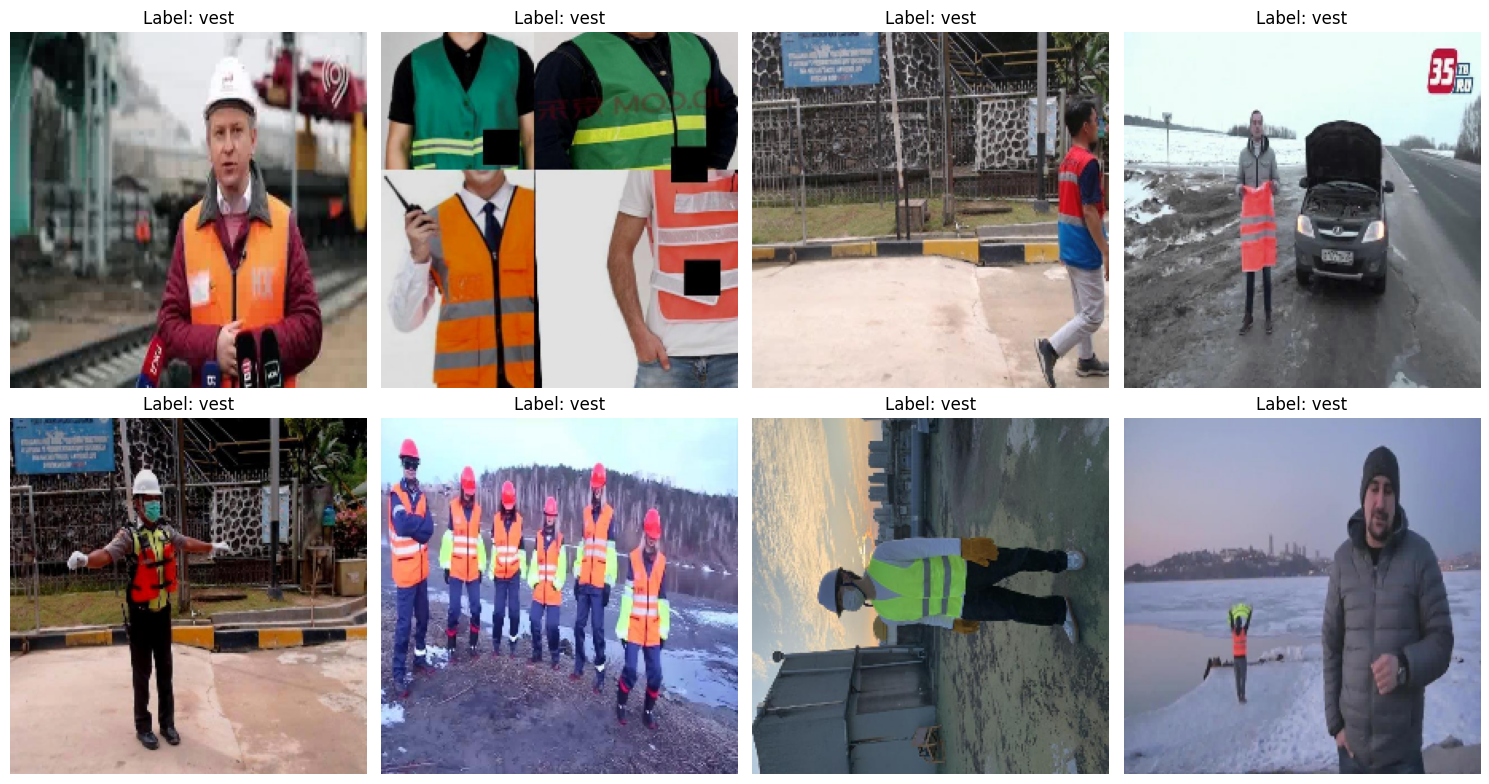

In [7]:
# ==========================================
# BAGIAN 7: VISUALISASI SAMPLE GAMBAR
# ==========================================

def plot_sample_images(X, y, label_encoder, num_samples=8):
    """
    Plot sample images dari dataset
    """
    plt.figure(figsize=(15, 8))
    
    for i in range(min(num_samples, len(X))):
        plt.subplot(2, 4, i+1)
        plt.imshow(X[i])
        label_name = label_encoder.inverse_transform([y[i]])[0]
        plt.title(f'Label: {label_name}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample gambar dari training set:")
plot_sample_images(X_train, y_train_encoded, label_encoder)


In [8]:
# ==========================================
# BAGIAN 8: DATA AUGMENTATION
# ==========================================
# Data augmentation untuk training

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation data tanpa augmentasi
val_datagen = ImageDataGenerator()

print("Data augmentation setup completed!")


Data augmentation setup completed!


In [9]:
# ==========================================
# BAGIAN 9: DEFINISI MODEL CNN
# ==========================================

def create_cnn_model(input_shape=(224, 224, 3), num_classes=2):
    """
    Create CNN model untuk klasifikasi vest/no-vest
    """
    model = keras.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Classifier
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
model = create_cnn_model(input_shape=(*IMG_SIZE, 3), num_classes=len(CLASS_NAMES))

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("Model Architecture:")
model.summary()


Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 108, 108, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,439,650 (5.49 MB)

 Trainable params: 1,437,666 (5.48 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [10]:

# ==========================================
# BAGIAN 10: CALLBACKS DAN TRAINING SETUP
# ==========================================

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'build/best_vest_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("Callbacks setup completed!")
print("Ready for training!")


Callbacks setup completed!
Ready for training!


In [11]:
# ==========================================
# BAGIAN 11: TRAINING MODEL
# ==========================================
import PIL
from PIL import Image

print("Starting model training...")

# Training dengan data augmentation
history = model.fit(
    train_datagen.flow(X_train, y_train_encoded, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_encoded),
    callbacks=callbacks,
    verbose=1
)


print("Training completed!")

Starting model training...
Epoch 1/35


KeyboardInterrupt: 

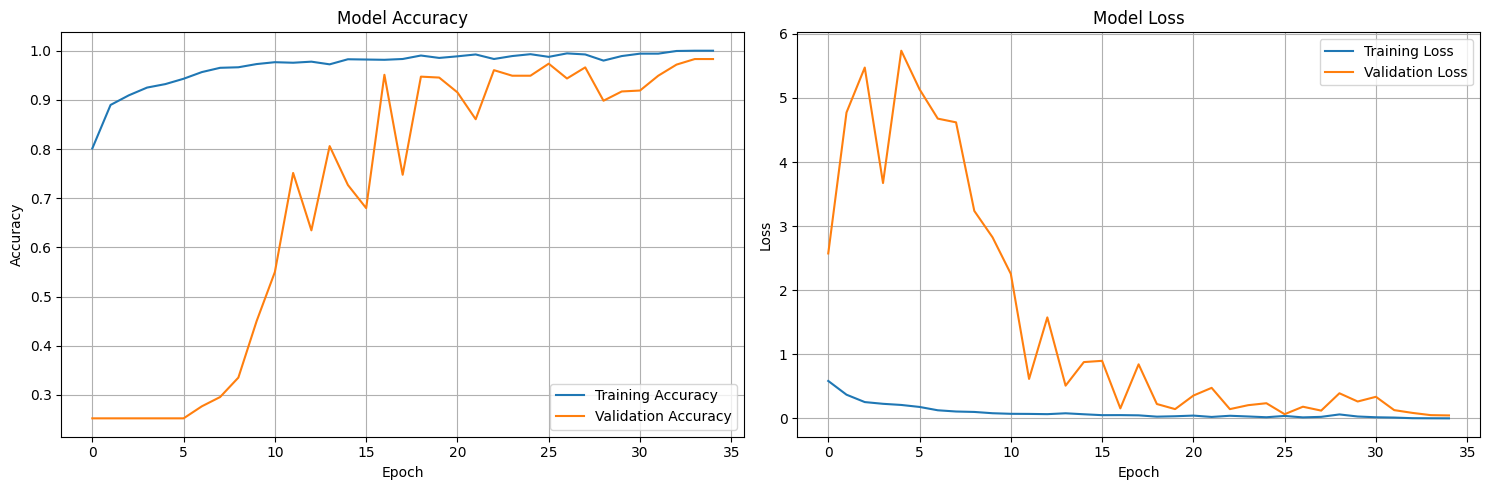

In [ ]:
# ==========================================
# BAGIAN 12: VISUALISASI TRAINING HISTORY
# ==========================================

def plot_training_history(history):
    """
    Plot training history
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Training Loss')
    axes[1].plot(history.history['val_loss'], label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


Evaluating on test set...
Test Accuracy: 0.9847
Test Loss: 0.0259
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 908ms/step

Classification Report:
              precision    recall  f1-score   support

     no-vest       0.94      1.00      0.97        29
        vest       1.00      0.98      0.99       102

    accuracy                           0.98       131
   macro avg       0.97      0.99      0.98       131
weighted avg       0.99      0.98      0.98       131



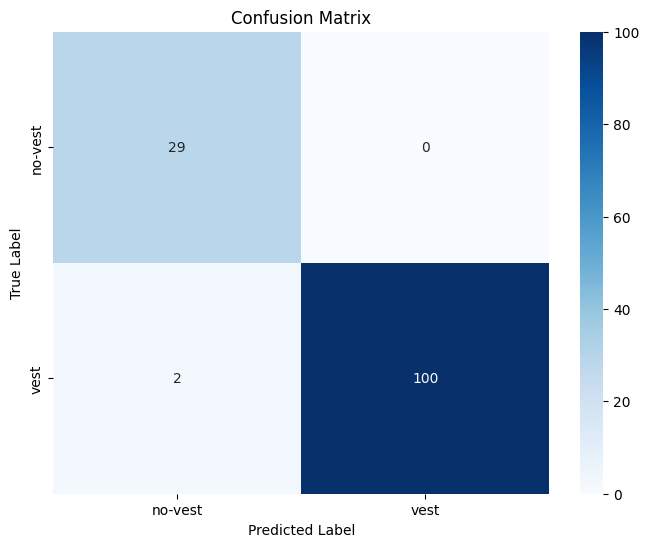

In [ ]:
# ==========================================
# BAGIAN 13: EVALUASI MODEL
# ==========================================

# Load best model
model.load_weights('best_vest_model.h5')

# Prediksi pada test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Prediksi detail
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, 
                          target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Testing predictions on sample images:


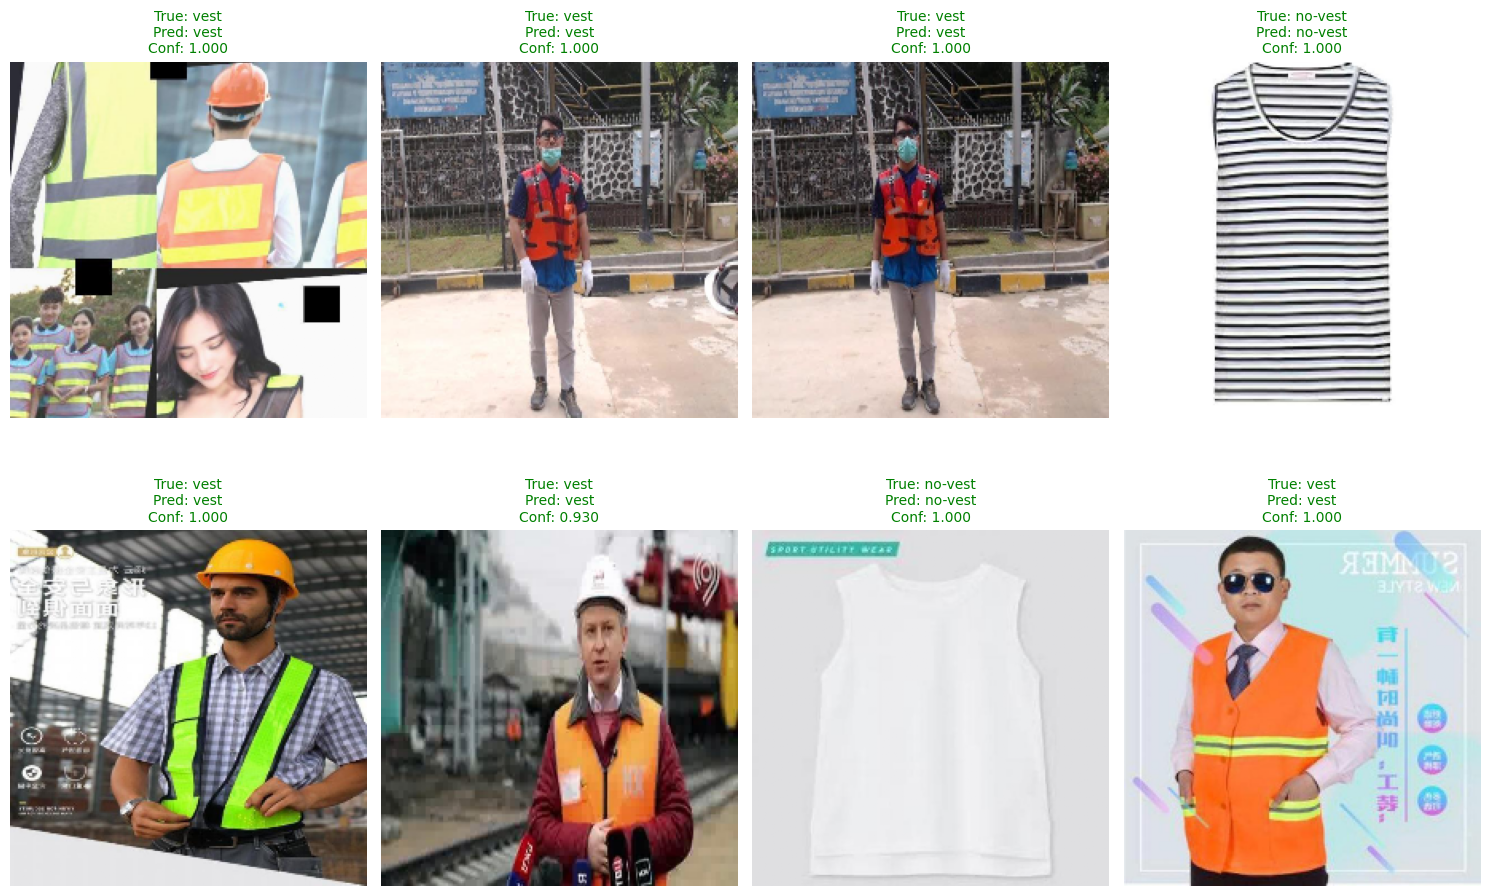


CNN VEST CLASSIFICATION COMPLETED!
Final Test Accuracy: 0.9847
Model saved as: best_vest_model.h5
You can now use predict_single_image() function for new predictions!


In [ ]:
# ==========================================
# BAGIAN 14: FUNGSI PREDIKSI UNTUK GAMBAR BARU
# ==========================================

def predict_single_image(model, img_path, label_encoder, img_size=IMG_SIZE):
    """
    Prediksi untuk single image
    """
    # Load dan preprocess gambar
    img = load_and_preprocess_image(img_path, img_size)
    if img is None:
        return None, None
    
    # Expand dimensions untuk batch
    img_batch = np.expand_dims(img, axis=0)
    
    # Prediksi
    pred_proba = model.predict(img_batch, verbose=0)
    pred_class = np.argmax(pred_proba, axis=1)[0]
    confidence = np.max(pred_proba)
    
    # Convert ke label name
    pred_label = label_encoder.inverse_transform([pred_class])[0]
    
    return pred_label, confidence

# Contoh penggunaan
def test_prediction_on_samples():
    """
    Test prediksi pada beberapa sample dari test set
    """
    plt.figure(figsize=(15, 10))
    
    # Ambil 8 sample random dari test set
    indices = np.random.choice(len(X_test), 8, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(2, 4, i+1)
        
        # Show image
        plt.imshow(X_test[idx])
        
        # Prediksi
        img_batch = np.expand_dims(X_test[idx], axis=0)
        pred_proba = model.predict(img_batch, verbose=0)
        pred_class = np.argmax(pred_proba, axis=1)[0]
        confidence = np.max(pred_proba)
        
        # True dan predicted labels
        true_label = label_encoder.inverse_transform([y_test_encoded[idx]])[0]
        pred_label = label_encoder.inverse_transform([pred_class])[0]
        
        # Color coding
        color = 'green' if true_label == pred_label else 'red'
        
        plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}', 
                 color=color, fontsize=10)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Testing predictions on sample images:")
test_prediction_on_samples()

print("\n" + "="*50)
print("CNN VEST CLASSIFICATION COMPLETED!")
print("="*50)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print("Model saved as: best_vest_model.h5")
print("You can now use predict_single_image() function for new predictions!")